In [17]:
import pandas as pd
import numpy as np

PATH = "RT_IOT2022_FULL.csv"

sample_df = (
    pd.read_csv(PATH).reset_index(drop=True)
)
print(sample_df.shape)

(209959, 84)


In [19]:
print("Columns:", sample_df.columns.tolist())
print("\nBasic info:")
sample_df.info()

# Separate types
num_cols = sample_df.select_dtypes(include="number").columns.tolist()
cat_cols = sample_df.select_dtypes(exclude="number").columns.drop("Attack_type").tolist()
print(f"\n{len(num_cols)} numeric, {len(cat_cols)} categorical")

Columns: ['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min', 'flow_pkts_payload.max', 'flow_pkts_payload.tot', 'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd_iat.min', 'fwd_iat.max', 'fwd_iat.tot', '

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numeric = num_cols
categorical = cat_cols   # 'proto', 'service'

pipe = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical),
    ],
    remainder="drop",
)
X = pipe.fit_transform(sample_df)

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=0)   # keep 90 % variance
X_pca = pca.fit_transform(X)
print("Explained variance by first 10 PCs:", np.round(pca.explained_variance_ratio_[:10], 3))

Explained variance by first 10 PCs: [0.264 0.151 0.106 0.07  0.053 0.05  0.032 0.023 0.022 0.018]


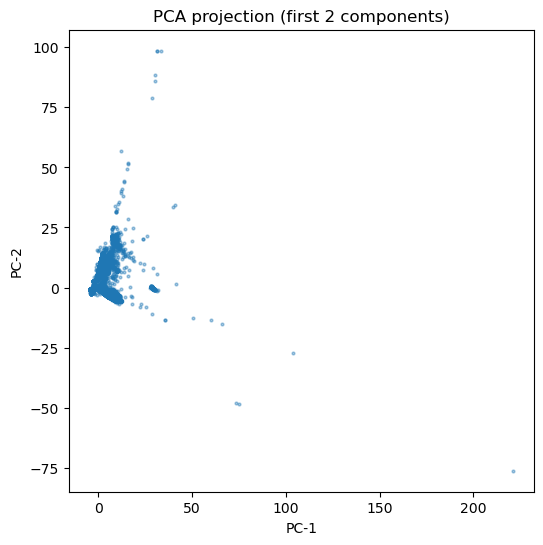

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=4, alpha=0.4)
plt.title("PCA projection (first 2 components)")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.show()

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = {}
for k in range(2,11):
    km = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(X_pca)
    sil[k] = silhouette_score(X_pca, km.labels_)
best_k = max(sil, key=sil.get)
print(sil)
print("Best k =", best_k)

{2: 0.4667954395336213, 3: 0.553161326736745, 4: 0.48894295832776036, 5: 0.5153708298227998, 6: 0.5307766665964995, 7: 0.5043680891771272, 8: 0.49155211691228157, 9: 0.4997134051171998, 10: 0.5025259048910632}
Best k = 3


In [29]:
km = KMeans(n_clusters=best_k, n_init="auto", random_state=0).fit(X_pca)
sample_df["cluster"] = km.labels_
cluster_summary = sample_df.groupby("cluster")["Attack_type"].value_counts(normalize=True).mul(100).round(1)
print(cluster_summary.unstack(fill_value=0).T)   # rows = attack type, cols = cluster

cluster                        0     1     2
Attack_type                                 
ARP_poisioning               4.5   5.8   0.2
Alexa                       13.4  65.8  99.7
DDOS_Slowloris               0.1   1.4   0.0
DOS_SYN_Hping               72.7   0.0   0.0
MQTT_Publish                 0.0  13.8   0.0
Metasploit_Brute_Force_SSH   0.0   0.1   0.0
NMAP_FIN_SCAN                0.0   0.0   0.0
NMAP_OS_DETECTION            1.5   0.0   0.0
NMAP_TCP_scan                0.8   0.0   0.0
NMAP_UDP_SCAN                2.0   0.0   0.0
NMAP_XMAS_TREE_SCAN          1.5   0.0   0.0
Thing_Speak                  3.3  12.6   0.0
Wipro_bulb                   0.1   0.5   0.0


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

y = LabelEncoder().fit_transform(sample_df["Attack_type"])
mi = mutual_info_classif(X, y, random_state=0)

feature_names = categorical + numeric
mi_df = (
    pd.DataFrame({"feature": feature_names, "MI": mi})
      .sort_values("MI", ascending=False)
      .head(15)
)
print(mi_df.to_string(index=False))

              feature       MI
flow_pkts_payload.min 1.147387
     fwd_subflow_pkts 1.143742
 fwd_pkts_payload.min 1.143094
 bwd_pkts_payload.std 1.122262
 fwd_pkts_payload.max 1.112502
  flow_ECE_flag_count 1.112015
flow_pkts_payload.max 1.108830
             idle.avg 1.033280
    flow_pkts_per_sec 1.025182
              service 1.023090
 fwd_init_window_size 1.010349
flow_pkts_payload.tot 0.995096
          bwd_iat.std 0.987389
            id.orig_p 0.960110
         flow_iat.min 0.958565


In [43]:
import pandas as pd
from sklearn.utils import resample

df = sample_df.copy()
max_per_class = 4000

balanced_chunks = []
for label, g in df.groupby('Attack_type'):
    balanced_chunks.append(
        resample(g,
                 n_samples=min(len(g), max_per_class),
                 random_state=0,
                 replace=False)
    )
balanced_df = pd.concat(balanced_chunks).reset_index(drop=True)

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numeric = num_cols
categorical = cat_cols   # 'proto', 'service'

pipe = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical),
    ],
    remainder="drop",
)
X = pipe.fit_transform(balanced_df)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=0)   # keep 90 % variance
X_pca = pca.fit_transform(X)
print("Explained variance by first 10 PCs:", np.round(pca.explained_variance_ratio_[:10], 3))

Explained variance by first 10 PCs: [0.205 0.171 0.088 0.073 0.058 0.053 0.041 0.032 0.028 0.021]


In [51]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=15).fit(X_pca)  # tweak eps a bit
balanced_df['cluster'] = db.labels_

In [53]:
balanced_df['cluster']


0        -1
1        -1
2         0
3         1
4         0
         ..
28449    -1
28450    -1
28451    -1
28452     0
28453    66
Name: cluster, Length: 28454, dtype: int64

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                # used only for pretty heatmaps
from collections import Counter

from sklearn.preprocessing   import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans, DBSCAN
from sklearn.metrics         import (silhouette_score, silhouette_samples,
                                     davies_bouldin_score,
                                     adjusted_rand_score, homogeneity_score,
                                     completeness_score)

# A quick plot helper
def plot_pca_scatter(xy, labels, title, ax=None):
    if ax is None: ax = plt.gca()
    scatter = ax.scatter(xy[:,0], xy[:,1], c=labels, s=12, alpha=.6, cmap='tab10')
    ax.set_xlabel('PC-1'); ax.set_ylabel('PC-2'); ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title='cluster', loc='best', fontsize=8)

In [57]:
print(balanced_df['Attack_type'].value_counts())
balanced_df.shape

Attack_type
ARP_poisioning                4000
Alexa                         4000
DOS_SYN_Hping                 4000
MQTT_Publish                  4000
Thing_Speak                   4000
NMAP_UDP_SCAN                 2590
NMAP_XMAS_TREE_SCAN           2010
NMAP_OS_DETECTION             2000
NMAP_TCP_scan                 1002
DDOS_Slowloris                 534
Wipro_bulb                     253
Metasploit_Brute_Force_SSH      37
NMAP_FIN_SCAN                   28
Name: count, dtype: int64


(28454, 85)

In [59]:
num_cols = balanced_df.select_dtypes(include='number').columns.tolist()
cat_cols = balanced_df.select_dtypes(exclude='number').drop('Attack_type', axis=1).columns.tolist()

pipe = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
])

X = pipe.fit_transform(balanced_df)
y_true = LabelEncoder().fit_transform(balanced_df['Attack_type'])

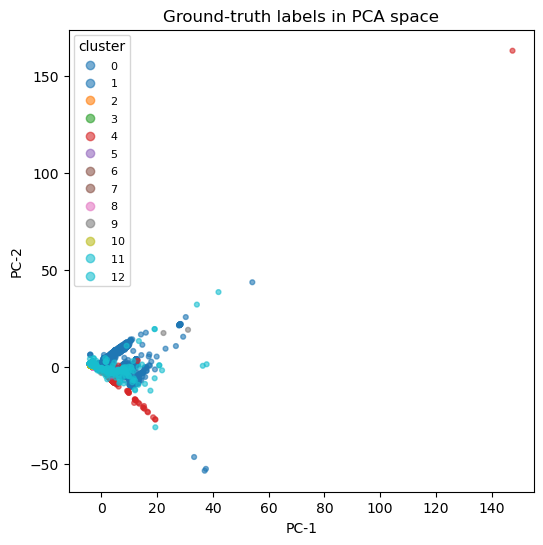

In [61]:
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plot_pca_scatter(X_pca, y_true, 'Ground-truth labels in PCA space')
plt.show()

In [63]:
sil = {}
for k in range(2,11):
    km = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(X)
    sil[k] = silhouette_score(X, km.labels_)
best_k = max(sil, key=sil.get)
print('Silhouette per k:', sil, '\nChosen k =', best_k)

km = KMeans(n_clusters=best_k, n_init='auto', random_state=0).fit(X)
labels_km = km.labels_

Silhouette per k: {2: 0.35582703926504317, 3: 0.22255647464416706, 4: 0.2639121049408936, 5: 0.28440752361826255, 6: 0.2883618112598766, 7: 0.28908121523065505, 8: 0.34140461541517864, 9: 0.3698060485731255, 10: 0.3755610318164674} 
Chosen k = 10


In [65]:
db = DBSCAN(eps=0.7, min_samples=15).fit(X_pca)   # tune eps for your data
labels_db = db.labels_

In [67]:
def internal_metrics(X, labels, name=''):
    mask = labels >= 0                      # DBSCAN gives -1 for noise
    print(f'\n{name} clusters: {Counter(labels[mask])}')
    print('Silhouette:', silhouette_score(X[mask], labels[mask]))
    print('Davies-Bouldin:', davies_bouldin_score(X[mask], labels[mask]))

internal_metrics(X,  labels_km, 'K-Means')
internal_metrics(X,  labels_db, 'DBSCAN')


K-Means clusters: Counter({4: 8662, 6: 4442, 1: 3614, 3: 3264, 5: 3022, 8: 2276, 2: 2054, 9: 1101, 0: 18, 7: 1})
Silhouette: 0.3755610318164674
Davies-Bouldin: 1.1240998718224844

DBSCAN clusters: Counter({0: 25698, 1: 2364, 2: 95, 3: 21, 4: 19})
Silhouette: 0.4159054918593425
Davies-Bouldin: 0.6180029400795884


In [68]:
def external_metrics(true, pred, name=''):
    mask = pred >= 0
    print(f'\n{name} (ignoring noise):')
    print('Adjusted Rand Index  :', adjusted_rand_score(true[mask], pred[mask]))
    print('Homogeneity / Completeness:', (homogeneity_score(true[mask], pred[mask]),
                                          completeness_score(true[mask], pred[mask])))

external_metrics(y_true, labels_km, 'K-Means')
external_metrics(y_true, labels_db, 'DBSCAN')


K-Means (ignoring noise):
Adjusted Rand Index  : 0.43916260392219597
Homogeneity / Completeness: (0.5933548230215165, 0.6851963331017763)

DBSCAN (ignoring noise):
Adjusted Rand Index  : 0.018523206633312573
Homogeneity / Completeness: (0.07987944129815588, 0.5511704153525079)


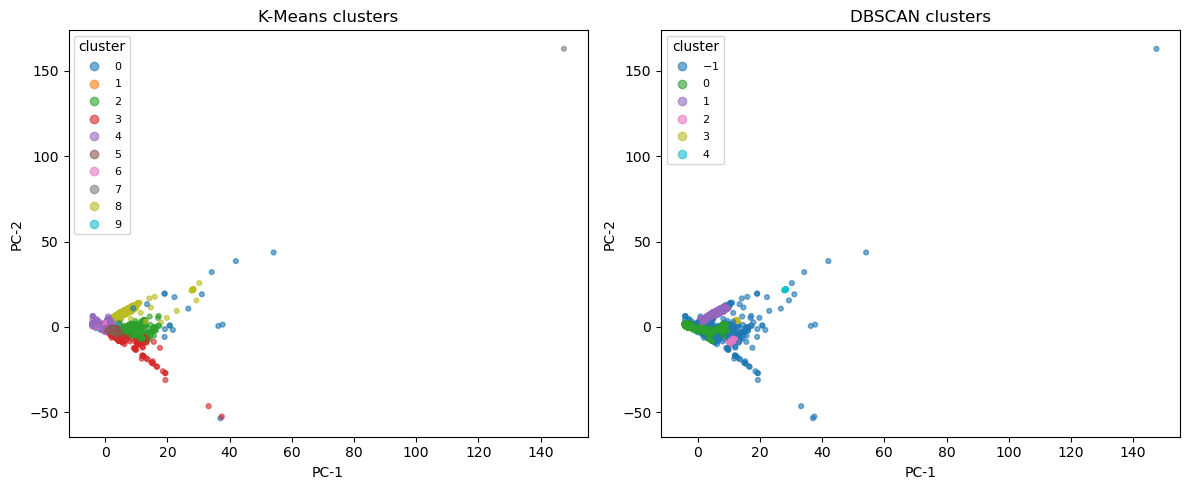

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
plot_pca_scatter(X_pca, labels_km, 'K-Means clusters', ax1)
plot_pca_scatter(X_pca, labels_db, 'DBSCAN clusters', ax2)
plt.tight_layout(); plt.show()

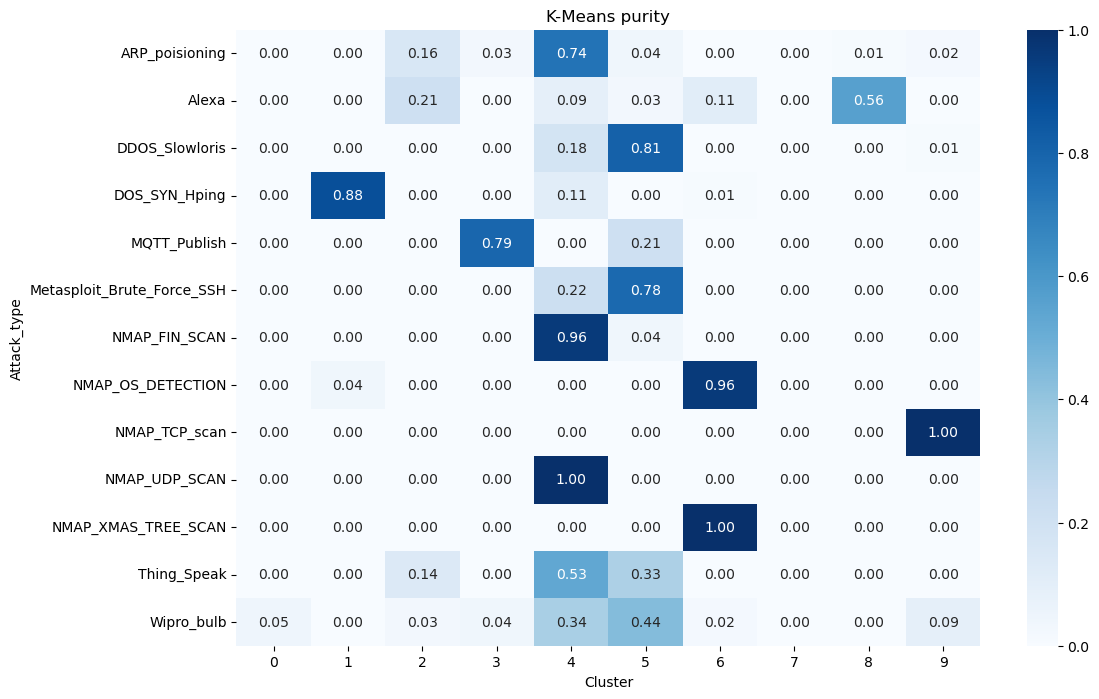

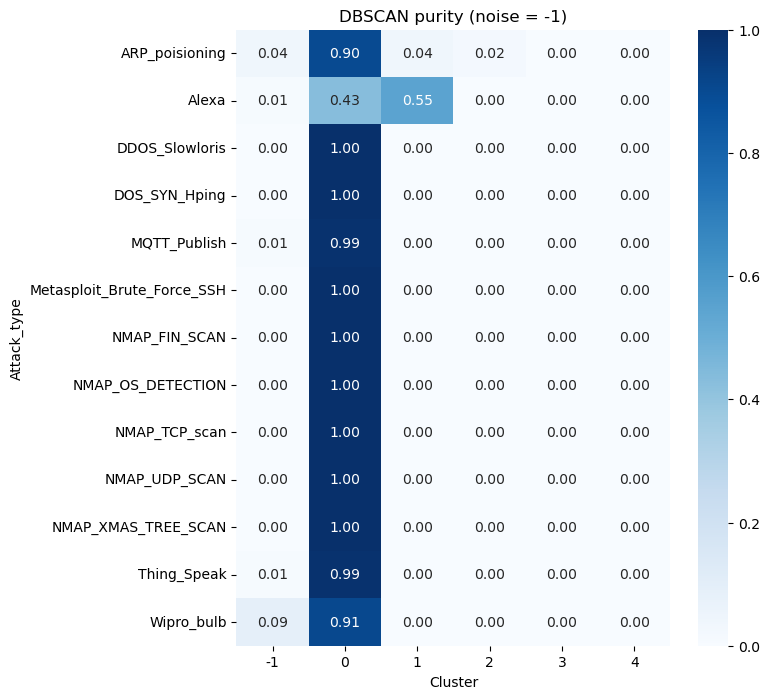

In [73]:
def heatmap(true_series, cluster_labels, title):
    crosstab = pd.crosstab(true_series, cluster_labels, normalize='index').round(2)
    plt.figure(figsize=(cluster_labels.max()+3,8))
    sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='.2f')
    plt.title(title); plt.ylabel('Attack_type'); plt.xlabel('Cluster'); plt.show()

heatmap(balanced_df['Attack_type'], labels_km, 'K-Means purity')
heatmap(balanced_df['Attack_type'], labels_db, 'DBSCAN purity (noise = -1)')

In [75]:
X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
X_df['cluster'] = labels_km

global_mean = X_df.drop('cluster', axis=1).mean()

cluster_profiles = {}
for c, grp in X_df.groupby('cluster'):
    cluster_profiles[c] = (grp.drop('cluster', axis=1).mean() - global_mean).abs().sort_values(ascending=False).head(7)

for c, prof in cluster_profiles.items():
    print(f'\nTop distinguishing features for cluster {c}:')
    print(prof)


Top distinguishing features for cluster 0:
fwd_iat.min     31.631976
flow_iat.min    31.627213
id.orig_p       31.627212
idle.min        30.514628
active.min      24.833607
bwd_iat.min     23.804900
fwd_pkts_tot    20.130490
dtype: float64

Top distinguishing features for cluster 1:
flow_iat.avg           2.054343
flow_CWR_flag_count    2.000525
bwd_data_pkts_tot      1.716983
fwd_pkts_per_sec       1.716841
fwd_data_pkts_tot      1.716598
proto                  1.043141
idle.avg               0.738770
dtype: float64

Top distinguishing features for cluster 2:
flow_pkts_payload.tot    2.525534
bwd_pkts_payload.tot     2.335842
flow_pkts_payload.max    2.253526
bwd_pkts_payload.max     2.234575
bwd_pkts_payload.std     2.172108
fwd_pkts_payload.tot     2.163950
fwd_pkts_payload.std     2.163057
dtype: float64

Top distinguishing features for cluster 3:
active.avg               2.533049
idle.max                 2.511610
flow_pkts_payload.std    2.469924
active.std               2.469633